### set up

# Short intro

In [2]:
## prepare for the shap package
!pip install keras==2.2.4

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
  Using cached https://mirrors.aliyun.com/pypi/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Using cached https://mirrors.aliyun.com/pypi/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
You should consider upgrading via the '/environment/python/versions/3.7.4/bin/python3.7 -m pip install --upgrade pip' command.


In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/featurize/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
## use eagerly to enable the numpy() function
tf.compat.v1.enable_eager_execution()

import tensorflow.keras

import tensorflow.keras.backend



from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

/home/featurize/data/README
/home/featurize/data/movie_titles.csv
/home/featurize/data/combined_data_3.txt
/home/featurize/data/qualifying.txt
/home/featurize/data/netflix-prize-data.zip
/home/featurize/data/combined_data_2.txt
/home/featurize/data/combined_data_1.txt
/home/featurize/data/probe.txt
/home/featurize/data/combined_data_4.txt


In [11]:
tf.__version__

'2.3.1'

# Import data

In [4]:
# DataFrame to store all imported data
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w') # write all data into a csv file

files = ['../data/combined_data_1.txt',
         '../data/combined_data_2.txt',
         '../data/combined_data_3.txt',
         '../data/combined_data_4.txt']

# Remove the line with movie_id: and add a new column of movie_id
# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

# Read all data into a pd dataframe, to generate a tabular data
df = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])

df

Opening file: ../data/combined_data_1.txt


NameError: name 'data' is not defined

In [5]:
# Read all data into a pd dataframe, to generate a tabular data
df = pd.read_csv('../netflix/data.csv', names=['movie_id', 'user_id','rating','date'])

df

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
100480502,17770,1790158,4,2005-11-01
100480503,17770,1608708,3,2005-07-19
100480504,17770,234275,1,2004-08-07
100480505,17770,255278,4,2004-05-28


# Preprocess data

From dataframe df, let's take only a smaller dataset of 2000 top rated movies and 100000 top users (who gave the most rates) and save into new df: lite_rating_df

In [6]:
lite_rating_df = pd.DataFrame()

group = df.groupby('user_id')['rating'].count()
top_users = group.sort_values(ascending=False)[:10000] # top users reschedule from 10000,rating_m correspnds to the movie_id

group = df.groupby('movie_id')['rating'].count()
top_movies = group.sort_values(ascending=False)[:2000] # top mivies reschedule from 2000

lite_rating_df = df.join(top_users, rsuffix='_u', how='inner', on='user_id') # user id who gives the rating 
lite_rating_df = lite_rating_df.join(top_movies, rsuffix='_m', how='inner', on='movie_id') # movie id which receive the rating

# Re-name the users and movies for uniform name from 0..2000 and 10000
user_enc = LabelEncoder()
lite_rating_df['user'] = user_enc.fit_transform(lite_rating_df['user_id'].values)
movie_enc = LabelEncoder()
lite_rating_df['movie'] = movie_enc.fit_transform(lite_rating_df['movie_id'].values)

n_movies = lite_rating_df['movie'].nunique()
n_users = lite_rating_df['user'].nunique()

# print(n_movies, n_users)
lite_rating_df

,movie_id,user_id,rating,date,rating_u,rating_m,user,movie
5149,8,1488844,4,2005-05-12,2206,14910,5594,0
5883,8,1227322,5,2005-05-31,4752,14910,4588,0
6183,8,525356,4,2005-08-26,4913,14910,1946,0
6310,8,401047,2,2005-06-15,2119,14910,1465,0
7140,8,883478,5,2005-10-10,3222,14910,3261,0
...,...,...,...,...,...,...,...,...
45663998,8163,778937,3,2005-06-10,1284,12553,2876,914
45668920,8163,1230845,3,2005-02-18,1277,12553,4604,914
45670283,8163,733887,4,2005-01-04,1779,12553,2703,914
45666732,8163,1645937,3,2005-02-01,1106,12553,6178,914


Prepare data for training

In [12]:
X = lite_rating_df[['user', 'movie']].values
y = lite_rating_df['rating'].values

# Split train and test data (for test model performance at last)
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

# Set the embedding dimension d of Matrix factorization
e_dimension = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]


# Build and train deep learning model

The embeddings is used to represent each user and each movie in the data. 
The dot product of user embedding matrix (size: n_users x e_dimension) and movie embedding matrix (size: n_movies x e_dimension) is a good approximation of the rating from user for movie. The model's goal is to minimize the distqace between this dot product and the ratings (training target)

In [14]:
# Build user and movie embedding matrix
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(user)
u = Reshape((e_dimension,))(u)
movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(movie)
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])
# Build last deep learning layers 
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.001), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  tf.keras.callbacks.ModelCheckpoint(  
                      filepath='Model_2',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  

history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_2")

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500000      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        100000      input_4[0][0]                    
_______________________________________________________________________________________

## visualize the training and validation loss

training and validation loss

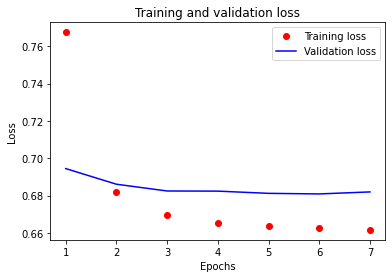

In [6]:
# Visualize the training and validation loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


test loss in the test data

In [22]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

NameError: name 'model' is not defined

In [26]:
import tensorflow as tf
## use eagerly to enable the numpy() function
tf.compat.v1.enable_eager_execution()

m = keras.metrics.RootMeanSquaredError()
m.update_state(new_model.predict(X_test_array), y_test)
m.result().numpy()

ValueError: tf.enable_eager_execution must be called at program startup.

# Interpretability

## Deep SHAP

In [14]:
import tensorflow as tf

new_model = tf.keras.models.load_model('../netflix/Model_1')

# check the structure
new_model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        100000      input_2[0][0]                    
_______________________________________________________________________________________

In [31]:
from pandas.core.frame import DataFrame
x_user = X_train_array[0] ## user
x_movie = X_train_array[1] ## movie
X_features = {"x_user" : x_user,
            "x_movie" : x_movie}#将列表a，b转换成字典
X_train_df = DataFrame(X_features)#将字典转换成为数据框
print(X_train_df)

         x_user  x_movie
0          2705     1498
1          2920      980
2          2895      524
3          3942      779
4          3875      221
...         ...      ...
7795345    1939     1327
7795346    4543      375
7795347    2650     1543
7795348    9797      728
7795349    7486       39

[7795350 rows x 2 columns]


In [29]:
y_train_df = {"y_train" : y_train}
y_train_df = DataFrame(y_train_df)
print(y_train_df)



         y_train
0              3
1              3
2              3
3              5
4              3
...          ...
7795345        3
7795346        5
7795347        2
7795348        2
7795349        4

[7795350 rows x 1 columns]


In [ ]:
## import the SHAP library
import shap

# initialize js methods for visualization
shap.initjs()

# reload the model

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=model,
                                 data=X_train_array)

# Fit the explainer on a subset of the data (you can try all but then gets slower)
shap_values = explainer_shap.shap_values(
#                                             X=.values,
                                        X=X_train_df.values[:500],
                                      ranked_outputs=True)

In [ ]:
## individual attributions inferred by the model
shap.force_plot(explainer_shap.expected_value,
                shap_values[0][0],
                feature_names=X_train_array.columns)

shap.force_plot(explainer_shap.expected_value,
                shap_values[0][0][1],
                X_train_array.values[:500][0],
                feature_names=X_train_array.columns,)

shap.force_plot(explainer_shap.expected_value,
                shap_values[0][0][1],
                X_train_array.values[:500][0],
                feature_names=X_train_array.columns,)

In [ ]:
## outputs of shapley values
# to get the output value and base value
record = 1 # this is just to pick one record in the dataset 
base_value = explainer_2.expected_value
output= base_value + np.sum(shap_values[0][0][record])
print('base value: ',base_value)
print('output value: ',output)

#sanity check that the ouput value is equal to the actual prediction
print(np.round(output,decimals=1) == np.round(model.predict(X_train_array.values)[record],decimals=1))


# to get the shape values or each feature
shap_df = pd.DataFrame(list(dict(zip(X_train_array.columns.values,base_value)).items()),
             columns=['features','shapvals']).sort_values(by='shapvals', ascending=True)
print(shap_df)

In [ ]:
## get the overall contribution of each feature variable
shap.summary_plot(shap_values[0], X_train.values[:500], feature_names=X_train.columns)